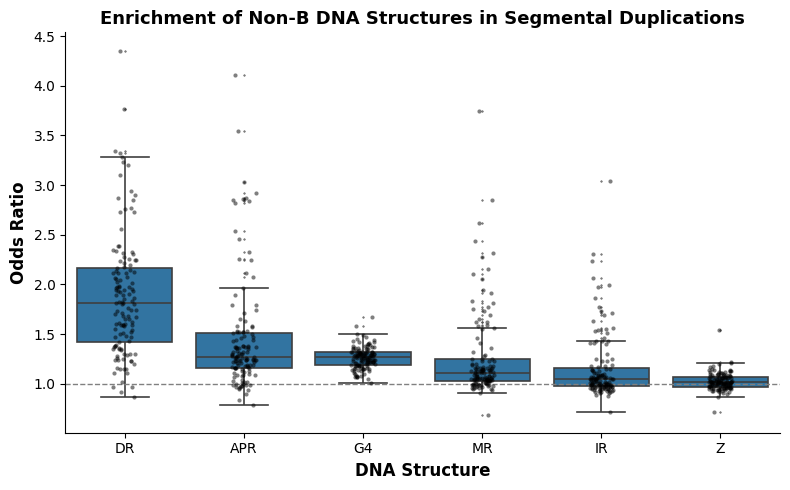

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your CSV
df = pd.read_csv("/home/alextu/scratch/segdup_analysis/final_results_SegDup.csv")
df = df.dropna(subset=["structure", "odds_ratio"])
df = df[df["odds_ratio"] > 0]

# Compute median odds ratio per structure and sort descending
median_order = (
    df.groupby("structure")["odds_ratio"]
      .median()
      .sort_values(ascending=False)
      .index.tolist()
)

# Palette (red for G4, purple for others)
palette = {"G4": "#1f77b4", "MR": "#1f77b4", "DR": "#1f77b4",
           "IR": "#1f77b4", "APR": "#1f77b4", "Z": "#1f77b4"}

# Plot
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="structure", y="odds_ratio",
            order=median_order, hue="structure", palette=palette,
            fliersize=0.5, linewidth=1.2, legend=False)
sns.stripplot(data=df, x="structure", y="odds_ratio",
              order=median_order, color="black", size=3, alpha=0.5, jitter=True)

plt.axhline(1, color="gray", linestyle="--", linewidth=1)  # baseline OR=1
plt.xlabel("DNA Structure", fontsize=12, fontweight="bold")
plt.ylabel("Odds Ratio", fontsize=12, fontweight="bold")
plt.title("Enrichment of Non-B DNA Structures in Segmental Duplications", fontsize=13, fontweight="bold")
sns.despine()
plt.tight_layout()
plt.savefig("overall_nonB_segdup_enrichment.pdf")
plt.show()

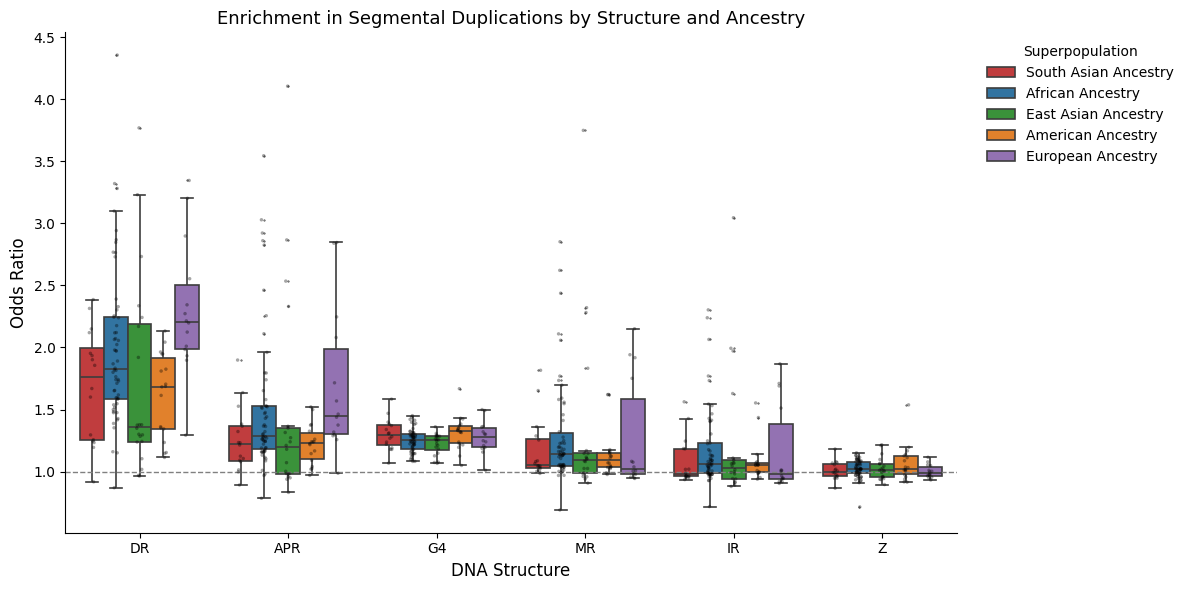

In [10]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

ENRICH_CSV   = "/home/alextu/scratch/segdup_analysis/final_results_SegDup.csv"
ANCESTRY_CSV = "/home/alextu/scratch/igsr_samples.tsv"   # update path

# ---------- Enrichment ----------
df = pd.read_csv(ENRICH_CSV)
if "sample_hap" in df.columns:
    sample_series = df["sample_hap"]
elif "sample" in df.columns:
    sample_series = df["sample"]
else:
    raise ValueError("Need a 'sample_hap' or 'sample' column to join ancestry.")

df["Sample name"] = sample_series.astype(str).str.extract(r"^([A-Z]{2}\d{5})", expand=False)
df = df.dropna(subset=["structure", "odds_ratio", "Sample name"])
df = df[df["odds_ratio"] > 0]

# ---------- Robust ancestry read ----------
# Use pandas' Sniffer: sep=None + engine='python' will infer comma vs tab cleanly, even with quoted commas
anc = pd.read_csv(ANCESTRY_CSV, sep=None, engine="python")

# Normalize column names (strip + lowercase) for flexible matching
norm = {c: c.strip().lower().replace(" ", "_") for c in anc.columns}
anc = anc.rename(columns=norm)

# Find usable columns
name_col = next((c for c in anc.columns if c in {"sample_name","sample name","sample"}), None)
sp_name_col = next((c for c in anc.columns if c in {"superpopulation_name","superpopulation name"}), None)
sp_code_col = next((c for c in anc.columns if c in {"superpopulation_code","superpopulation code"}), None)

if name_col is None:
    raise ValueError("Ancestry file must include 'Sample name' (or similar).")
if sp_name_col is None and sp_code_col is None:
    raise ValueError("Ancestry file must include 'Superpopulation name' or 'Superpopulation code'.")

# Keep minimal columns; prefer human-readable name
keep_cols = [name_col]
if sp_name_col: keep_cols.append(sp_name_col)
if sp_code_col: keep_cols.append(sp_code_col)
anc = anc[keep_cols].drop_duplicates()

anc["Ancestry"] = anc[sp_name_col] if sp_name_col else anc[sp_code_col]
anc = anc.rename(columns={name_col: "Sample name"})

# ---------- Merge ----------
dfm = df.merge(anc[["Sample name","Ancestry"]], on="Sample name", how="left").dropna(subset=["Ancestry"])

# ---------- Order by median OR (overall, like your original) ----------
median_order = (
    dfm.groupby("structure", observed=True)["odds_ratio"]
       .median()
       .sort_values(ascending=False)
       .index.tolist()
)

# ---------- Palette ----------
default_palette = {
    "African Ancestry": "#1f77b4",
    "American Ancestry": "#ff7f0e",
    "East Asian Ancestry": "#2ca02c",
    "European Ancestry": "#9467bd",
    "South Asian Ancestry": "#d62728",
    "AFR": "#1f77b4", "AMR": "#ff7f0e", "EAS": "#2ca02c", "EUR": "#9467bd", "SAS": "#d62728",
}
unique_anc = dfm["Ancestry"].astype(str).unique().tolist()
palette = {a: default_palette.get(a, sns.color_palette("tab10")[i % 10])
           for i, a in enumerate(unique_anc)}

# ---------- Plot ----------
plt.figure(figsize=(12, 6))
# Boxplot
sns.boxplot(
    data=dfm, x="structure", y="odds_ratio",
    order=median_order, hue="Ancestry", palette=palette,
    fliersize=0.5, linewidth=1.2
)

# Stripplot (points) -- use 'palette' instead of 'color'
sns.stripplot(
    data=dfm, x="structure", y="odds_ratio",
    order=median_order, hue="Ancestry", dodge=True,
    palette={a: "black" for a in dfm["Ancestry"].unique()},
    size=2.5, alpha=0.35
)
# Clean legend: keep one set of handles
handles, labels = plt.gca().get_legend_handles_labels()
n = len(unique_anc)
plt.legend(handles[:n], labels[:n], title="Superpopulation",
           bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

plt.axhline(1, color="gray", linestyle="--", linewidth=1)
plt.xlabel("DNA Structure", fontsize=12)
plt.ylabel("Odds Ratio", fontsize=12)
plt.title("Enrichment in Segmental Duplications by Structure and Ancestry", fontsize=13)
sns.despine()
plt.tight_layout()
plt.show()

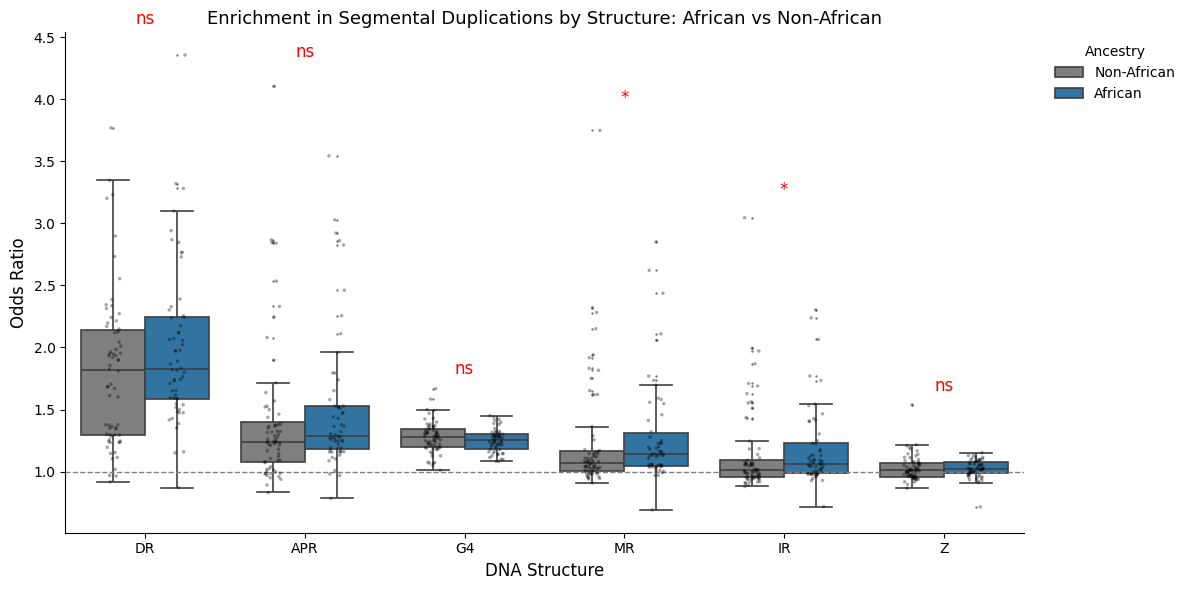

In [2]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu

ENRICH_CSV   = "/home/alextu/scratch/segdup_analysis/final_results_SegDup.csv"
ANCESTRY_CSV = "/home/alextu/scratch/igsr_samples.tsv"

# ---------- Enrichment ----------
df = pd.read_csv(ENRICH_CSV)
if "sample_hap" in df.columns:
    sample_series = df["sample_hap"]
elif "sample" in df.columns:
    sample_series = df["sample"]
else:
    raise ValueError("Need a 'sample_hap' or 'sample' column to join ancestry.")

df["Sample name"] = sample_series.astype(str).str.extract(r"^([A-Z]{2}\d{5})", expand=False)
df = df.dropna(subset=["structure", "odds_ratio", "Sample name"])
df = df[df["odds_ratio"] > 0]

# ---------- Ancestry read ----------
anc = pd.read_csv(ANCESTRY_CSV, sep=None, engine="python")
norm = {c: c.strip().lower().replace(" ", "_") for c in anc.columns}
anc = anc.rename(columns=norm)

name_col    = next((c for c in anc.columns if c in {"sample_name","sample name","sample"}), None)
sp_name_col = next((c for c in anc.columns if c in {"superpopulation_name","superpopulation name"}), None)
sp_code_col = next((c for c in anc.columns if c in {"superpopulation_code","superpopulation code"}), None)
if name_col is None or (sp_name_col is None and sp_code_col is None):
    raise ValueError("Ancestry file must have Sample name and Superpopulation (name or code).")

keep_cols = [name_col] + [c for c in [sp_name_col, sp_code_col] if c]
anc = anc[keep_cols].drop_duplicates().rename(columns={name_col: "Sample name"})

# Collapse to two groups: African vs Non-African
def collapse_afr(row):
    name = str(row.get(sp_name_col, "") or "").lower()
    code = str(row.get(sp_code_col, "") or "").upper()
    if "african" in name or code == "AFR":
        return "African"
    return "Non-African"

anc["Ancestry2"] = anc.apply(collapse_afr, axis=1)

# ---------- Merge ----------
dfm = df.merge(anc[["Sample name","Ancestry2"]], on="Sample name", how="left").dropna(subset=["Ancestry2"])

# ---------- Order by overall median OR ----------
median_order = (
    dfm.groupby("structure", observed=True)["odds_ratio"]
       .median()
       .sort_values(ascending=False)
       .index.tolist()
)

# ---------- Palette ----------
palette = {"African": "#1f77b4", "Non-African": "#7f7f7f"}

# ---------- Plot ----------
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=dfm, x="structure", y="odds_ratio",
    order=median_order, hue="Ancestry2", palette=palette,
    fliersize=0.5, linewidth=1.2
)

sns.stripplot(
    data=dfm, x="structure", y="odds_ratio",
    order=median_order, hue="Ancestry2", dodge=True,
    palette={"African": "black", "Non-African": "black"},
    size=2.5, alpha=0.35
)

# ---------- Mann–Whitney tests + annotate ----------
y_offsets = {}
for i, struct in enumerate(median_order):
    sub = dfm[dfm["structure"] == struct]
    afr_vals = sub.loc[sub["Ancestry2"] == "African", "odds_ratio"]
    non_vals = sub.loc[sub["Ancestry2"] == "Non-African", "odds_ratio"]
    if len(afr_vals) > 0 and len(non_vals) > 0:
        stat, p = mannwhitneyu(afr_vals, non_vals, alternative="two-sided")
        # pick y-position slightly above max
        ymax = sub["odds_ratio"].max()
        y = ymax * 1.05 if ymax > 0 else 1.05
        y_offsets[struct] = y
        if p < 0.001:
            star = "***"
        elif p < 0.01:
            star = "**"
        elif p < 0.05:
            star = "*"
        else:
            star = "ns"
        plt.text(i, y, star, ha="center", va="bottom", fontsize=12, color="red")

# Clean legend (keep one set)
handles, labels = plt.gca().get_legend_handles_labels()
n = len(palette)
plt.legend(handles[:n], labels[:n], title="Ancestry",
           bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

plt.axhline(1, color="gray", linestyle="--", linewidth=1)
plt.xlabel("DNA Structure", fontsize=12)
plt.ylabel("Odds Ratio", fontsize=12)
plt.title("Enrichment in Segmental Duplications by Structure: African vs Non-African", fontsize=13)
sns.despine()
plt.tight_layout()
plt.show()

Mann-Whitney U test: U=12982.00, p=7.76e-14


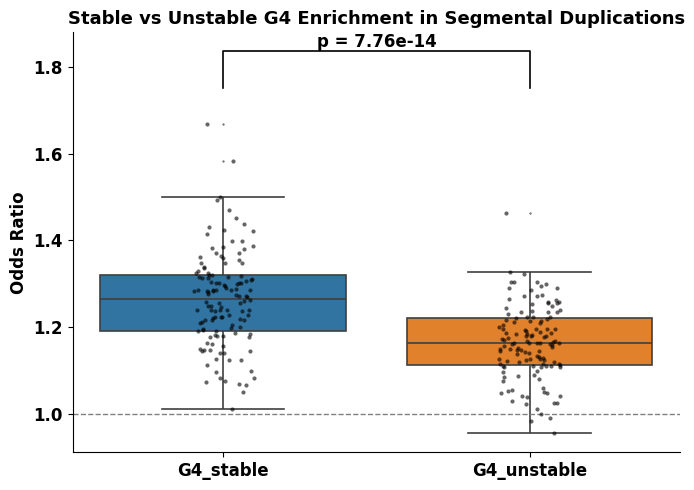

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# ====== LOAD DATA ======
df = pd.read_csv("/home/alextu/scratch/segdup_analysis/final_results_G4_stable_vs_unstable_SegDup.csv")

# keep only stable/unstable G4 rows
df = df[df["structure"].isin(["G4_stable", "G4_unstable"])]

# split groups
stable   = df.loc[df["structure"]=="G4_stable", "odds_ratio"]
unstable = df.loc[df["structure"]=="G4_unstable", "odds_ratio"]

# stats test
stat, pval = mannwhitneyu(stable, unstable, alternative="two-sided")
print(f"Mann-Whitney U test: U={stat:.2f}, p={pval:.2e}")

# ====== PLOT ======
plt.figure(figsize=(7,5))
palette = {"G4_stable":"#1f77b4", "G4_unstable":"#ff7f0e"}

sns.boxplot(data=df, x="structure", y="odds_ratio",
            order=["G4_stable","G4_unstable"],
            hue="structure", palette=palette,
            fliersize=0.5, linewidth=1.2, legend=False)
sns.stripplot(data=df, x="structure", y="odds_ratio",
              order=["G4_stable","G4_unstable"],
              color="black", size=3, alpha=0.6, jitter=True)

plt.axhline(1, color="gray", linestyle="--", linewidth=1)

plt.xlabel("", fontsize=12, fontweight="bold")
plt.xticks(fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")
plt.ylabel("Odds Ratio", fontsize=12, fontweight="bold")
plt.title("Stable vs Unstable G4 Enrichment in Segmental Duplications", fontsize=13, fontweight="bold")
sns.despine()

# annotate p-value on top
ymax = df["odds_ratio"].max()
x1, x2 = 0, 1
plt.plot([x1, x1, x2, x2], [ymax*1.05, ymax*1.1, ymax*1.1, ymax*1.05],
         lw=1.2, c="black")
plt.text((x1+x2)/2, ymax*1.1, f"p = {pval:.2e}",
         ha="center", va="bottom", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.savefig("stable_unstable_g4_segdup.pdf")
plt.show()

Mann-Whitney U test (IR): U=10065.00, p=3.61e-03 | n_stable=129, n_unstable=129


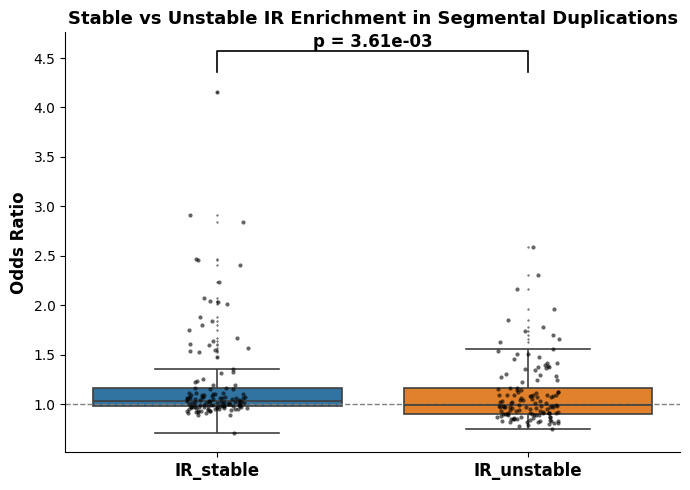

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import numpy as np

# ====== LOAD DATA ======
df = pd.read_csv("/home/alextu/scratch/segdup_analysis/final_results_IR_stable_vs_unstable_SegDup.csv")

# keep only stable/unstable IR rows
df = df[df["structure"].isin(["IR_stable", "IR_unstable"])].copy()

# split groups
stable   = df.loc[df["structure"]=="IR_stable", "odds_ratio"].astype(float)
unstable = df.loc[df["structure"]=="IR_unstable", "odds_ratio"].astype(float)

# stats test (Mann-Whitney U)
stat, pval = mannwhitneyu(stable, unstable, alternative="two-sided")
print(f"Mann-Whitney U test (IR): U={stat:.2f}, p={pval:.2e} | n_stable={stable.size}, n_unstable={unstable.size}")

# ====== PLOT ======
plt.figure(figsize=(7,5))
palette = {"IR_stable":"#1f77b4", "IR_unstable":"#ff7f0e"}

order = ["IR_stable","IR_unstable"]

sns.boxplot(data=df, x="structure", y="odds_ratio",
            order=order, hue="structure", palette=palette,
            fliersize=0.5, linewidth=1.2, legend=False)
sns.stripplot(data=df, x="structure", y="odds_ratio",
              order=order, color="black", size=3, alpha=0.6, jitter=True)

plt.axhline(1, color="gray", linestyle="--", linewidth=1)

plt.xlabel("", fontsize=12, fontweight="bold")
plt.xticks(fontsize=12, fontweight="bold")
plt.ylabel("Odds Ratio", fontsize=12, fontweight="bold")
plt.title("Stable vs Unstable IR Enrichment in Segmental Duplications", fontsize=13, fontweight="bold")
sns.despine()

# annotate p-value on top
ymax = np.nanmax(df["odds_ratio"].values)
x1, x2 = 0, 1
plt.plot([x1, x1, x2, x2], [ymax*1.05, ymax*1.1, ymax*1.1, ymax*1.05],
         lw=1.2, c="black")
plt.text((x1+x2)/2, ymax*1.1, f"p = {pval:.2e}",
         ha="center", va="bottom", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.savefig("stable_unstable_IR_segdup.pdf")
plt.show()

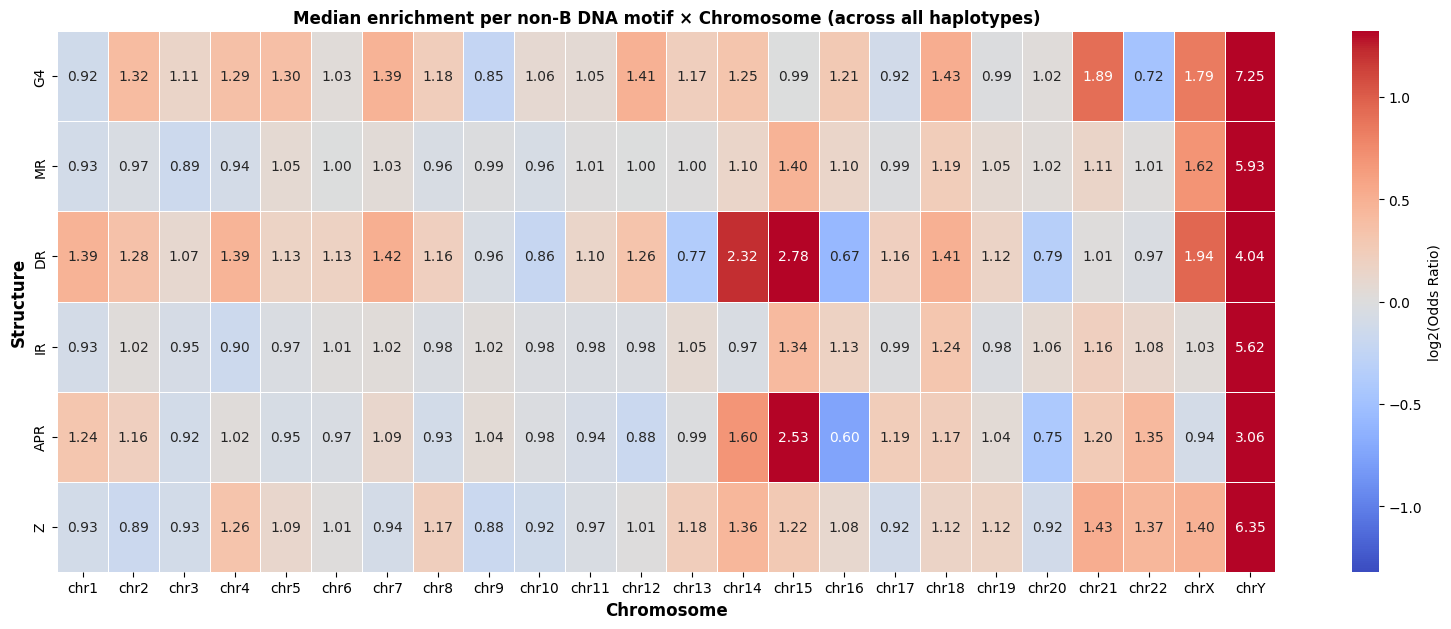

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

IN_CSV = "/home/alextu/scratch/segdup_analysis/final_results_SegDup_chroms.csv"
STRUCT_ORDER = ["G4", "MR", "DR", "IR", "APR", "Z"]
CHR_ORDER = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]

df = pd.read_csv(IN_CSV, usecols=["sample_hap", "chromosome", "structure", "odds_ratio"])
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["odds_ratio"])

present_chr = [c for c in CHR_ORDER if c in df["chromosome"].unique()]
present_structs = [s for s in STRUCT_ORDER if s in df["structure"].unique()]
df = df[df["chromosome"].isin(present_chr) & df["structure"].isin(present_structs)]
df["chromosome"] = pd.Categorical(df["chromosome"], categories=present_chr, ordered=True)
df["structure"]  = pd.Categorical(df["structure"],  categories=present_structs, ordered=True)

# 1) median within hap×chr×structure  (observed=True removes the warning)
per_hap = (
    df.groupby(["sample_hap", "chromosome", "structure"], observed=True, as_index=False)["odds_ratio"]
      .median()
)

# 2) median across haps per chr×structure  (observed=True removes the warning)
medians = (
    per_hap.groupby(["chromosome", "structure"], observed=True, as_index=False)["odds_ratio"]
           .median()
)

mat = medians.pivot(index="structure", columns="chromosome", values="odds_ratio")

# Color by log2(OR) centered at 0 => neutral (OR=1) is the middle color
mat_log2 = np.log2(mat)

# Make the color limits symmetric around 0 using robust percentiles
finite_vals = mat_log2.to_numpy()[np.isfinite(mat_log2.to_numpy())]
vmax = np.nanpercentile(np.abs(finite_vals), 95) if finite_vals.size else 1.0
vmin = -vmax

plt.figure(figsize=(16, 4 + 0.4 * len(present_structs)))
ax = sns.heatmap(
    mat_log2,
    cmap="coolwarm",
    center=0, vmin=vmin, vmax=vmax,
    annot=mat.round(2), fmt=".2f",  # annotate with raw OR, not log2
    linewidths=0.5, linecolor="white",
    cbar_kws={"label": "log2(Odds Ratio)"},
)

ax.set_xlabel("Chromosome", fontsize=12, fontweight="bold")
ax.set_ylabel("Structure", fontsize=12, fontweight="bold")
ax.set_title("Median enrichment per non-B DNA motif × Chromosome (across all haplotypes)", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.savefig("segdup_or_medians_heatmap.pdf")
plt.show()